In [3]:
import random
wGTID = 903653732
random.seed(a=wGTID)
print(random.randint(1,100))

21


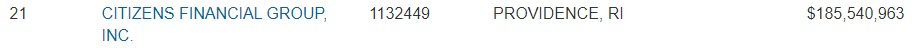

# CITIZENS FINANCIAL GROUP, INC
### Commercial & Consumer Banking
#### - Their primary business unit is for consumer and commercial banking and it operates in 11 states with over 1000 branches. Their largest assets classes as of 6/30/2021 were in real estate loans, commercial loans, and loans to individuals. With each making up 28.7%, 20.8% and 16% of their total assets respectively. 
### Citizens Securities, LLC
#### - This business unit handles the investing arm of the bank, it is devoted to consumers planning for retirement, education plans and personal portfolios. They offer a number of products such as IRAs, Fixed annuities, 529 College Savings Plans, Stocks Bonds, ETFs and Mutual Funds. In their latest NE1 you can see the percentage of orders they direct to venues for trading. Citadel Securities and Virtu Americas fulfill almost 90% of their orders for securities traded on NYSE or NASDAQ exchanges. 